In [ ]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
%%capture
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
    !tar -xvzf 'ibug_300W_large_face_landmark_dataset.tar.gz'
    !rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

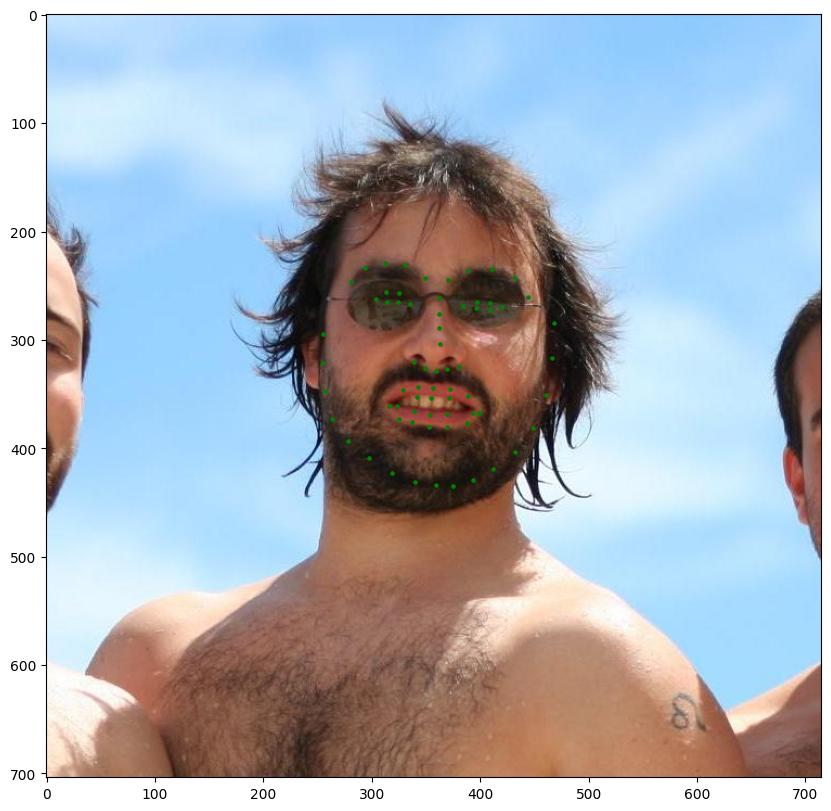

In [ ]:
file = open('ibug_300W_large_face_landmark_dataset/helen/trainset/100040721_1.pts')
points = file.readlines()[3:-1]

landmarks = []

for point in points:
    x,y = point.split(' ')
    landmarks.append([floor(float(x)), floor(float(y[:-1]))])

landmarks = np.array(landmarks)

plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread('ibug_300W_large_face_landmark_dataset/helen/trainset/100040721_1.jpg'))
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'g')
plt.show()

In [ ]:
class Transforms():
    def __init__(self):
        pass

    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))],
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3,
                                              contrast=0.3,
                                              saturation=0.3,
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)

        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [ ]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir = 'ibug_300W_large_face_landmark_dataset'

        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]

        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5

        return image, landmarks

dataset = FaceLandmarksDataset(Transforms())

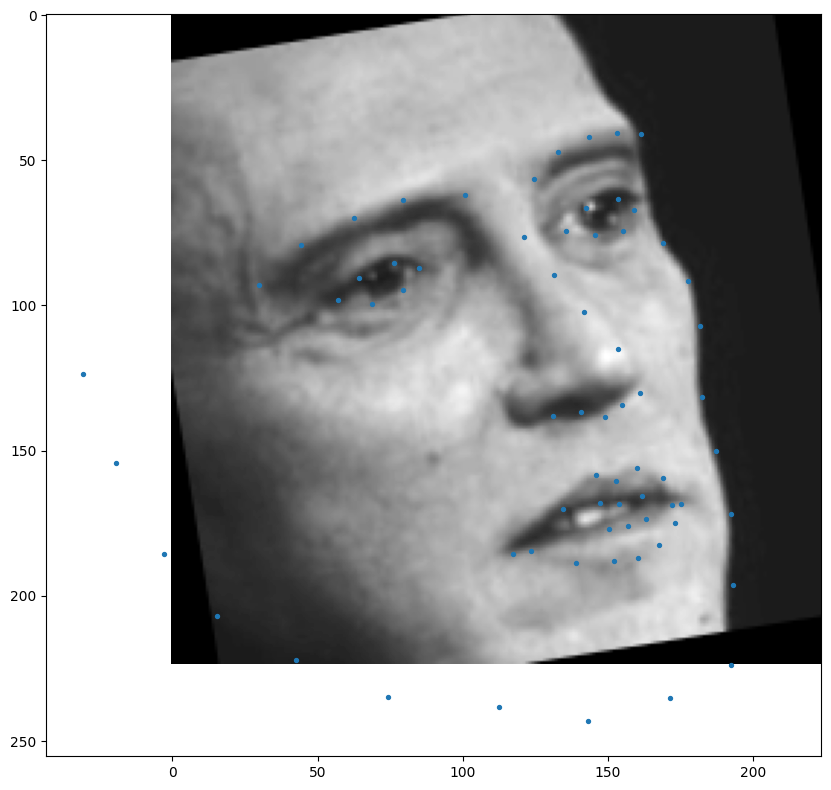

In [ ]:
image, landmarks = dataset[0]
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(10, 10))
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=8);

In [ ]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=4)

The length of Train set is 6000
The length of Valid set is 666


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])


In [ ]:
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        x=self.model(x)
        return x

In [ ]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))

    sys.stdout.flush()

Using device: cuda

--------------------------------------------------
Epoch: 1  Train Loss: 0.0189  Valid Loss: 0.0061
--------------------------------------------------

Minimum Validation Loss of 0.0061 at epoch 1/10
Model Saved


--------------------------------------------------
Epoch: 2  Train Loss: 0.0056  Valid Loss: 0.0053
--------------------------------------------------

Minimum Validation Loss of 0.0053 at epoch 2/10
Model Saved


--------------------------------------------------
Epoch: 3  Train Loss: 0.0048  Valid Loss: 0.0044
--------------------------------------------------

Minimum Validation Loss of 0.0044 at epoch 3/10
Model Saved


--------------------------------------------------
Epoch: 4  Train Loss: 0.0037  Valid Loss: 0.0032
--------------------------------------------------

Minimum Validation Loss of 0.0032 at epoch 4/10
Model Saved


--------------------------------------------------
Epoch: 5  Train Loss: 0.0026  Valid Loss: 0.0026
------------------------

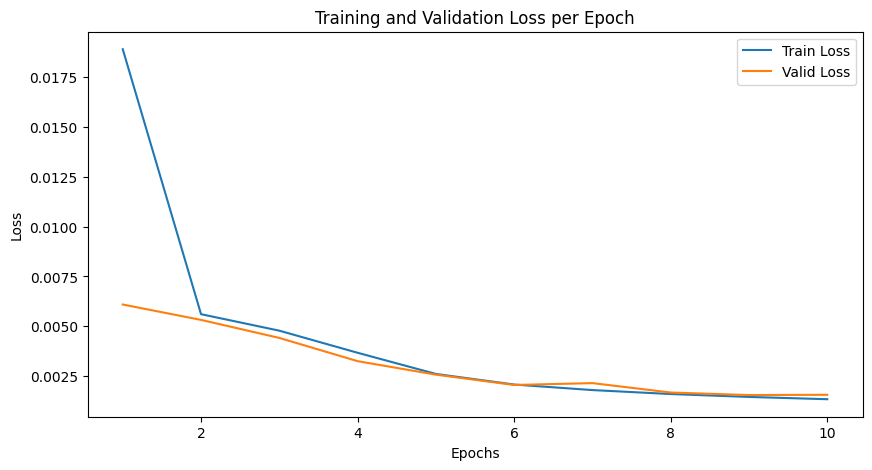

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt

# Set up device-agnostic code. It will use GPU if available, otherwise CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Assuming 'Network' and 'train_loader', 'valid_loader' are defined somewhere above this snippet.
network = Network().to(device)  # Move network to appropriate device

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = float('inf')
num_epochs = 10

train_losses = []
valid_losses = []

start_time = time.time()

for epoch in range(1, num_epochs + 1):

    loss_train = 0
    loss_valid = 0

    network.train()
    for step, (images, landmarks) in enumerate(train_loader, 1):

        images = images.to(device)
        landmarks = landmarks.view(landmarks.size(0), -1).to(device)

        optimizer.zero_grad()  # Clear gradients before calculation
        predictions = network(images)
        loss_train_step = criterion(predictions, landmarks)
        loss_train_step.backward()  # Calculate gradients
        optimizer.step()  # Update parameters

        loss_train += loss_train_step.item()
        running_loss = loss_train / step
        # print_overwrite(step, len(train_loader), running_loss, 'train')

    network.eval()
    with torch.no_grad():
        for step, (images, landmarks) in enumerate(valid_loader, 1):
            images = images.to(device)
            landmarks = landmarks.view(landmarks.size(0), -1).to(device)

            predictions = network(images)
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid / step
            # print_overwrite(step, len(valid_loader), running_loss, 'valid')

    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)

    train_losses.append(loss_train)
    valid_losses.append(loss_valid)

    print(f'\n--------------------------------------------------')
    print(f'Epoch: {epoch}  Train Loss: {loss_train:.4f}  Valid Loss: {loss_valid:.4f}')
    print('--------------------------------------------------')

    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), 'face_landmarks.pth')  # Save best model
        print(f"\nMinimum Validation Loss of {loss_min:.4f} at epoch {epoch}/{num_epochs}")
        print('Model Saved\n')

print('Training Complete')
print(f"Total Elapsed Time : {time.time() - start_time:.2f} s")

# Plot the graph between epochs and train/valid loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()


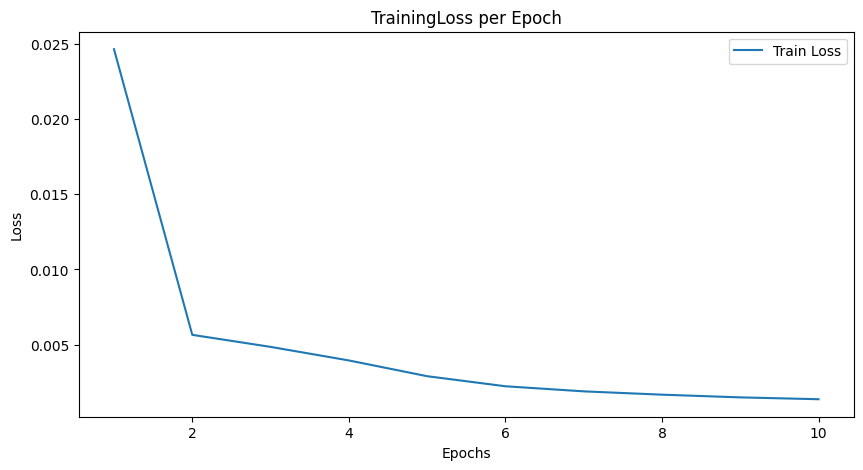

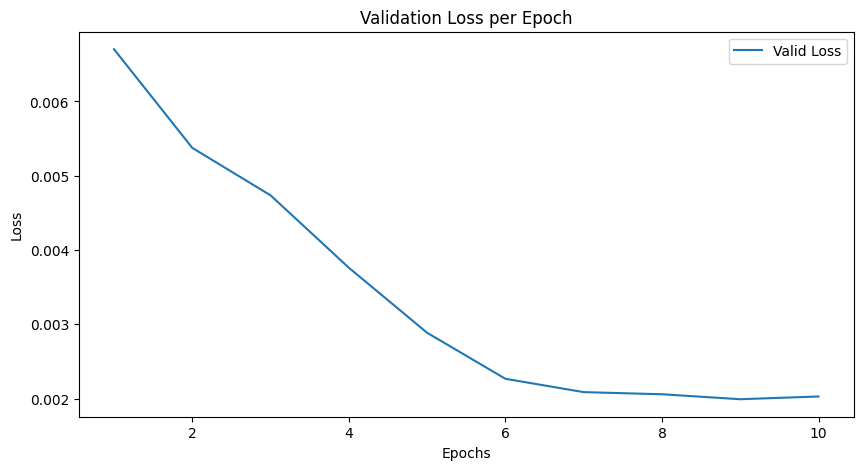

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('TrainingLoss per Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch')
plt.legend()
plt.show()



Total number of test images: 666
Elapsed Time : 1.377969741821289


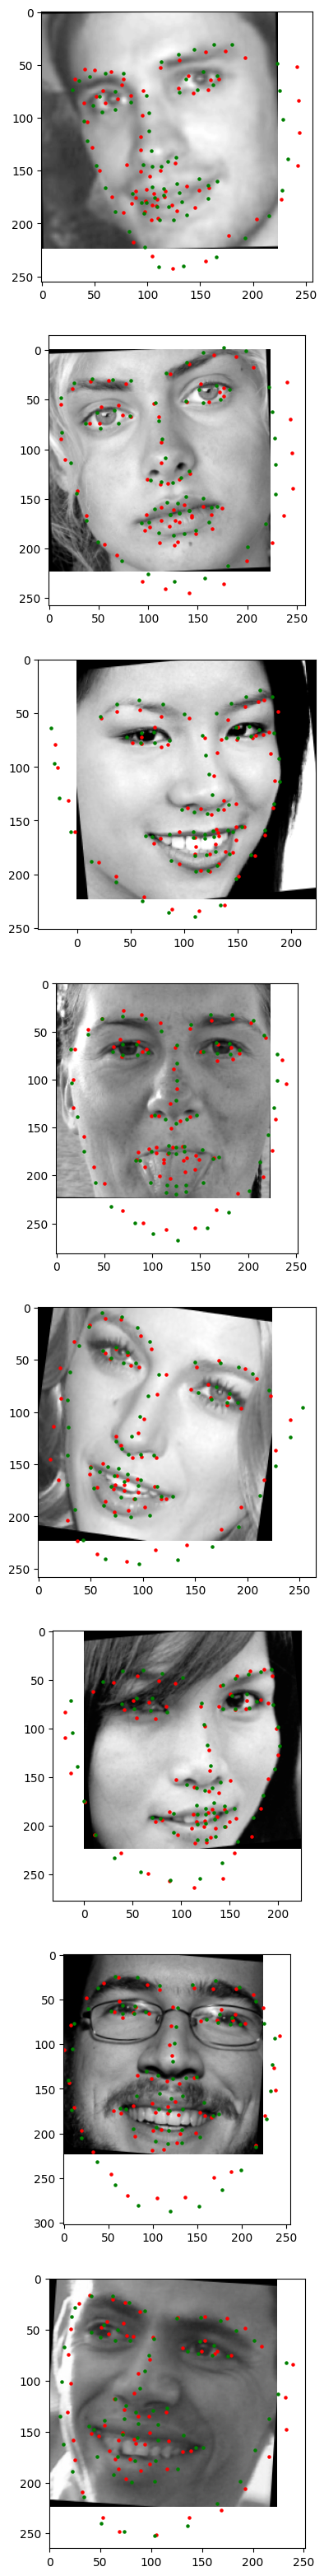

In [ ]:
start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('/content/face_landmarks.pth'))
    best_network.eval()

    images, landmarks = next(iter(valid_loader))

    images = images.cuda()
    landmarks = (landmarks + 0.5) * 224

    predictions = (best_network(images).cpu() + 0.5) * 224
    predictions = predictions.view(-1,68,2)

    plt.figure(figsize=(10,40))

    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
        plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)

print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time))


Epoch 1, Training Loss: 0.0011
valid: Step 84/84, Loss: 0.0014, Mean Error: 0.0434, Precision: 1.0000, Recall: 1.0000, Success Rate: 1.0000
Epoch: 1 Mean Error: 0.0426, Precision: 1.0000, Recall: 1.0000, Success Rate: 1.0000
Epoch 2, Training Loss: 0.0011
valid: Step 84/84, Loss: 0.0013, Mean Error: 0.0366, Precision: 1.0000, Recall: 1.0000, Success Rate: 1.0000
Epoch: 2 Mean Error: 0.0420, Precision: 1.0000, Recall: 1.0000, Success Rate: 1.0000
Epoch 3, Training Loss: 0.0010
valid: Step 84/84, Loss: 0.0011, Mean Error: 0.0289, Precision: 1.0000, Recall: 1.0000, Success Rate: 1.0000
Epoch: 3 Mean Error: 0.0386, Precision: 1.0000, Recall: 1.0000, Success Rate: 1.0000
Epoch 4, Training Loss: 0.0010
valid: Step 84/84, Loss: 0.0011, Mean Error: 0.0508, Precision: 1.0000, Recall: 1.0000, Success Rate: 1.0000
Epoch: 4 Mean Error: 0.0373, Precision: 1.0000, Recall: 1.0000, Success Rate: 1.0000
Epoch 5, Training Loss: 0.0009
valid: Step 84/84, Loss: 0.0011, Mean Error: 0.0399, Precision: 1.000

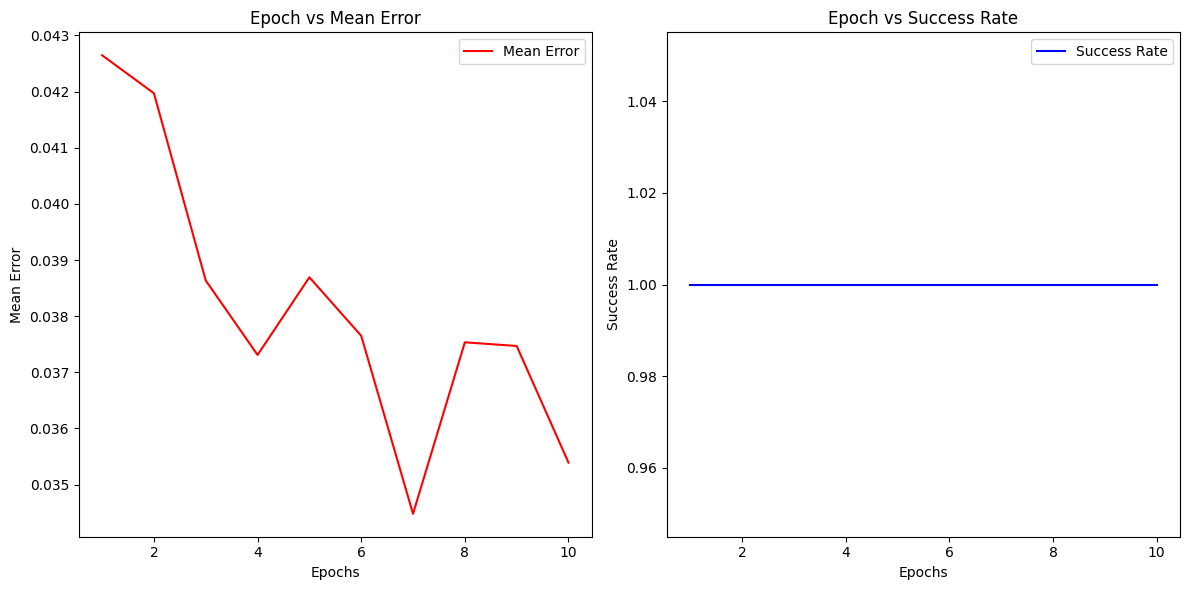

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define the evaluation metrics as functions
import sys

def print_overwrite(step, total_steps, loss, mode, mean_err, precision, recall, success_rate):
    """
    Updates the console output for the current validation step, displaying loss and evaluation metrics.
    """
    sys.stdout.write('\r')
    sys.stdout.write(f"{mode}: Step {step}/{total_steps}, Loss: {loss:.4f}, "
                     f"Mean Error: {mean_err:.4f}, Precision: {precision:.4f}, "
                     f"Recall: {recall:.4f}, Success Rate: {success_rate:.4f}")
    sys.stdout.flush()

def mean_error(predictions, ground_truth):
    return np.mean(np.linalg.norm(predictions - ground_truth, axis=2))

def precision_recall(predictions, ground_truth, threshold=5.0):
    distances = np.linalg.norm(predictions - ground_truth, axis=2)
    true_positives = (distances < threshold).sum(axis=1)  # sum per image
    possible_positives = ground_truth.shape[1]  # number of landmarks per image
    predicted_positives = predictions.shape[1]  # assumed to be the same as possible positives

    precision = true_positives / predicted_positives
    recall = true_positives / possible_positives
    return precision.mean(), recall.mean()  # average over all images

def success_rate(predictions, ground_truth, threshold=5.0):
    per_image_errors = np.mean(np.linalg.norm(predictions - ground_truth, axis=2), axis=1)  # mean per image
    successful_predictions = (per_image_errors < threshold).sum()
    total_images = predictions.shape[0]
    return successful_predictions / total_images

# Initialize lists to store metrics for each epoch
epochs = []
train_losses = []
valid_losses = []
valid_mean_errors = []
valid_precisions = []
valid_recalls = []
valid_success_rates = []

for epoch in range(num_epochs):
    network.train()
    running_loss = 0.0
    for step, (images, landmarks) in enumerate(train_loader, 1):
        images = images.to(device)
        landmarks = landmarks.view(landmarks.size(0), -1).to(device)

        optimizer.zero_grad()
        predictions = network(images)
        loss = criterion(predictions, landmarks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}")

    network.eval()
    with torch.no_grad():
        total_mean_error = 0
        total_precision = 0
        total_recall = 0
        total_success_rate = 0
        loss_valid = 0  # Initialize accumulated validation loss

        for step, (images, landmarks) in enumerate(valid_loader, 1):
            images = images.to(device)
            landmarks = landmarks.view(landmarks.size(0), -1).to(device)

            predictions = network(images)
            loss_valid_step = criterion(predictions, landmarks)

            predictions_np = predictions.cpu().numpy().reshape(-1, 68, 2)
            landmarks_np = landmarks.cpu().numpy().reshape(-1, 68, 2)

            mean_err = mean_error(predictions_np, landmarks_np)
            precision, recall = precision_recall(predictions_np, landmarks_np)
            success_rate_val = success_rate(predictions_np, landmarks_np)

            total_mean_error += mean_err
            total_precision += precision
            total_recall += recall
            total_success_rate += success_rate_val
            loss_valid += loss_valid_step.item()
            running_loss = loss_valid / step

            print_overwrite(step, len(valid_loader), running_loss, 'valid', mean_err, precision, recall, success_rate_val)

        avg_mean_error = total_mean_error / len(valid_loader)
        avg_precision = total_precision / len(valid_loader)
        avg_recall = total_recall / len(valid_loader)
        avg_success_rate = total_success_rate / len(valid_loader)
        valid_loss = loss_valid / len(valid_loader)

        # Store metrics
        epochs.append(epoch + 1)
        valid_losses.append(valid_loss)
        valid_mean_errors.append(avg_mean_error)
        valid_precisions.append(avg_precision)
        valid_recalls.append(avg_recall)
        valid_success_rates.append(avg_success_rate)

        print(f'\nEpoch: {epoch+1} Mean Error: {avg_mean_error:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, Success Rate: {avg_success_rate:.4f}')

# Plotting the graphs
plt.figure(figsize=(12, 6))

# Plot for Epoch vs. Validation Mean Error
plt.subplot(1, 2, 1)
plt.plot(epochs, valid_mean_errors, 'r', label='Mean Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Error')
plt.title('Epoch vs Mean Error')
plt.legend()

# Plot for Epoch vs. Validation Success Rate (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(epochs, valid_success_rates, 'b', label='Success Rate')
plt.xlabel('Epochs')
plt.ylabel('Success Rate')
plt.title('Epoch vs Success Rate')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1, Training Loss: 0.0008
valid: Step 84/84, Loss: 0.0010, Mean Error: 0.0384, Precision: 1.0000, Recall: 1.0000, Success Rate: 1.0000
Epoch: 1 Mean Error: 0.0362, NME: 0.0889, Precision: 1.0000, Recall: 1.0000, Success Rate: 1.0000
Epoch 2, Training Loss: 0.0008
valid: Step 84/84, Loss: 0.0012, Mean Error: 0.0441, Precision: 1.0000, Recall: 1.0000, Success Rate: 1.0000
Epoch: 2 Mean Error: 0.0400, NME: 0.0986, Precision: 1.0000, Recall: 1.0000, Success Rate: 1.0000
Epoch 3, Training Loss: 0.0008
valid: Step 84/84, Loss: 0.0010, Mean Error: 0.0345, Precision: 1.0000, Recall: 1.0000, Success Rate: 1.0000
Epoch: 3 Mean Error: 0.0354, NME: 0.0872, Precision: 1.0000, Recall: 1.0000, Success Rate: 1.0000
Epoch 4, Training Loss: 0.0007
valid: Step 84/84, Loss: 0.0013, Mean Error: 0.0381, Precision: 1.0000, Recall: 1.0000, Success Rate: 1.0000
Epoch: 4 Mean Error: 0.0428, NME: 0.1053, Precision: 1.0000, Recall: 1.0000, Success Rate: 1.0000
Epoch 5, Training Loss: 0.0007
valid: Step 84/84

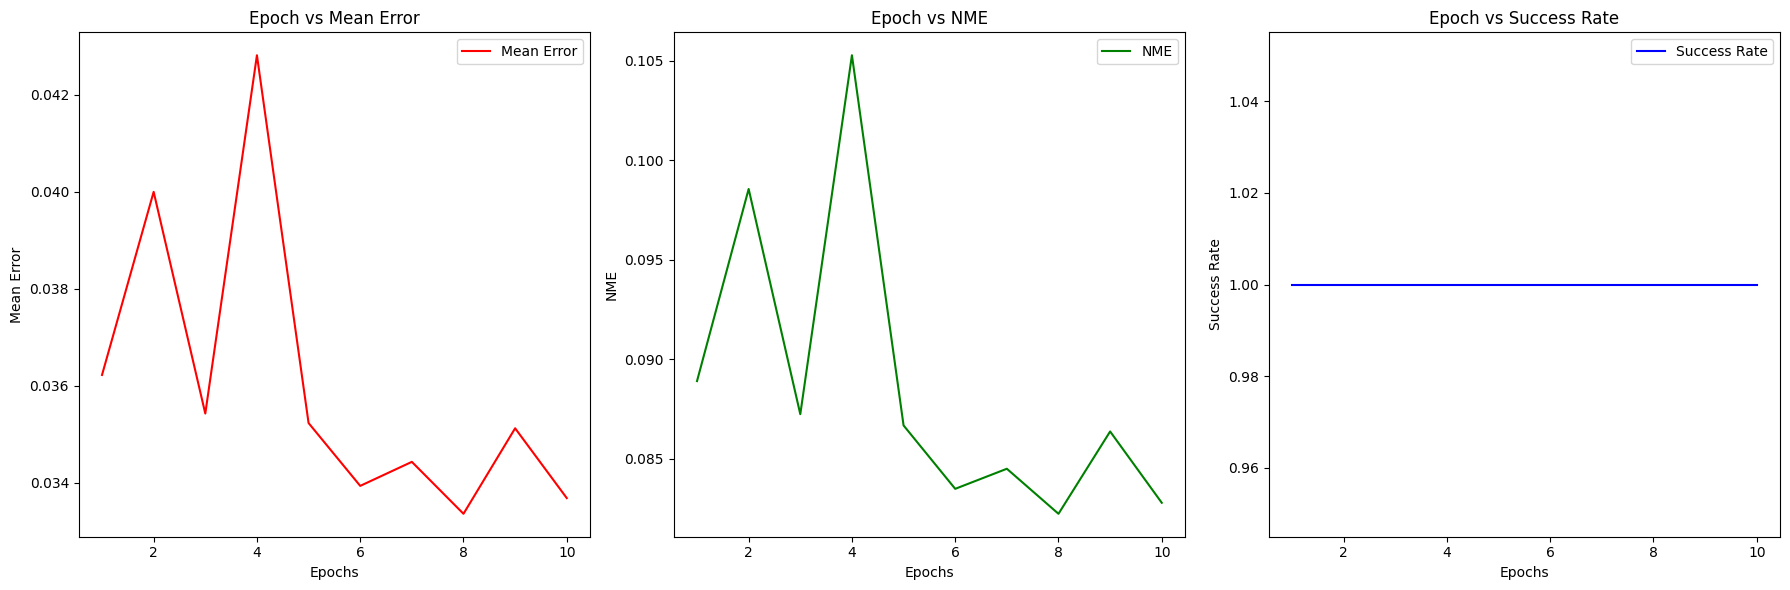

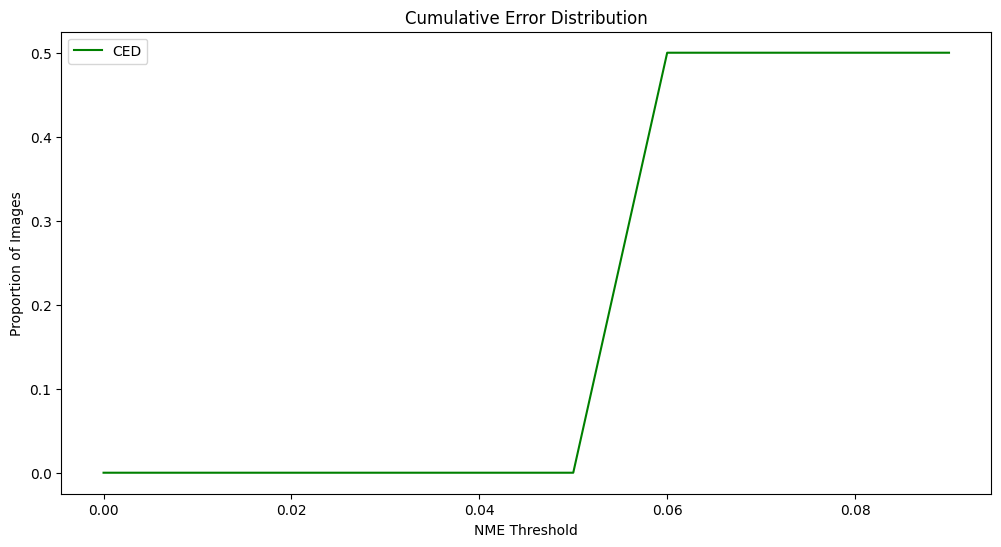

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define the evaluation metrics as functions
import sys

def print_overwrite(step, total_steps, loss, mode, mean_err, precision, recall, success_rate):
    """
    Updates the console output for the current validation step, displaying loss and evaluation metrics.
    """
    sys.stdout.write('\r')
    sys.stdout.write(f"{mode}: Step {step}/{total_steps}, Loss: {loss:.4f}, "
                     f"Mean Error: {mean_err:.4f}, Precision: {precision:.4f}, "
                     f"Recall: {recall:.4f}, Success Rate: {success_rate:.4f}")
    sys.stdout.flush()

def mean_error(predictions, ground_truth):
    return np.mean(np.linalg.norm(predictions - ground_truth, axis=2))

def precision_recall(predictions, ground_truth, threshold=5.0):
    distances = np.linalg.norm(predictions - ground_truth, axis=2)
    true_positives = (distances < threshold).sum(axis=1)  # sum per image
    possible_positives = ground_truth.shape[1]  # number of landmarks per image
    predicted_positives = predictions.shape[1]  # assumed to be the same as possible positives

    precision = true_positives / predicted_positives
    recall = true_positives / possible_positives
    return precision.mean(), recall.mean()  # average over all images

def success_rate(predictions, ground_truth, threshold=5.0):
    per_image_errors = np.mean(np.linalg.norm(predictions - ground_truth, axis=2), axis=1)  # mean per image
    successful_predictions = (per_image_errors < threshold).sum()
    total_images = predictions.shape[0]
    return successful_predictions / total_images

def inter_ocular_distance(landmarks):
    left_eye = landmarks[:, 36:42].mean(axis=1)  # Indices for left eye landmarks
    right_eye = landmarks[:, 42:48].mean(axis=1)  # Indices for right eye landmarks
    return np.linalg.norm(left_eye - right_eye, axis=1)

def normalized_mean_error(predictions, ground_truth):
    nme_list = []
    for pred, gt in zip(predictions, ground_truth):
        norm_factor = inter_ocular_distance(gt.reshape(-1, 68, 2)).mean()
        error = np.linalg.norm(pred - gt, axis=1).mean()
        nme_list.append(error / norm_factor)
    return np.mean(nme_list)

def cumulative_error_distribution(predictions, ground_truth, thresholds):
    nmes = []
    for pred, gt in zip(predictions, ground_truth):
        norm_factor = inter_ocular_distance(gt.reshape(-1, 68, 2)).mean()
        error = np.linalg.norm(pred - gt, axis=1).mean()
        nmes.append(error / norm_factor)

    cdf = []
    for threshold in thresholds:
        cdf.append((np.array(nmes) <= threshold).mean())
    return cdf

# Initialize lists to store metrics for each epoch
epochs = []
train_losses = []
valid_losses = []
valid_mean_errors = []
valid_nme_errors = []  # Corrected the name of the list
valid_precisions = []
valid_recalls = []
valid_success_rates = []

nme_thresholds = np.arange(0, 0.1, 0.01)  # Example thresholds for CED

for epoch in range(num_epochs):
    network.train()
    running_loss = 0.0
    for step, (images, landmarks) in enumerate(train_loader, 1):
        images = images.to(device)
        landmarks = landmarks.view(landmarks.size(0), -1).to(device)

        optimizer.zero_grad()
        predictions = network(images)
        loss = criterion(predictions, landmarks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}")

    network.eval()
    with torch.no_grad():
        total_mean_error = 0
        total_nme = 0
        total_precision = 0
        total_recall = 0
        total_success_rate = 0
        loss_valid = 0

        for step, (images, landmarks) in enumerate(valid_loader, 1):
            images = images.to(device)
            landmarks = landmarks.view(landmarks.size(0), -1).to(device)

            predictions = network(images)
            loss_valid_step = criterion(predictions, landmarks)

            predictions_np = predictions.cpu().numpy().reshape(-1, 68, 2)
            landmarks_np = landmarks.cpu().numpy().reshape(-1, 68, 2)

            mean_err = mean_error(predictions_np, landmarks_np)
            nme = normalized_mean_error(predictions_np, landmarks_np)
            precision, recall = precision_recall(predictions_np, landmarks_np)
            success_rate_val = success_rate(predictions_np, landmarks_np)

            total_mean_error += mean_err
            total_nme += nme
            total_precision += precision
            total_recall += recall
            total_success_rate += success_rate_val
            loss_valid += loss_valid_step.item()
            running_loss = loss_valid / step

            print_overwrite(step, len(valid_loader), running_loss, 'valid', mean_err, precision, recall, success_rate_val)

        avg_mean_error = total_mean_error / len(valid_loader)
        avg_nme = total_nme / len(valid_loader)
        avg_precision = total_precision / len(valid_loader)
        avg_recall = total_recall / len(valid_loader)
        avg_success_rate = total_success_rate / len(valid_loader)
        valid_loss = loss_valid / len(valid_loader)
        ced = cumulative_error_distribution(predictions_np, landmarks_np, nme_thresholds)

        epochs.append(epoch + 1)
        valid_losses.append(valid_loss)
        valid_mean_errors.append(avg_mean_error)
        valid_nme_errors.append(avg_nme)  # Corrected the name of the list
        valid_precisions.append(avg_precision)
        valid_recalls.append(avg_recall)
        valid_success_rates.append(avg_success_rate)

        print(f'\nEpoch: {epoch+1} Mean Error: {avg_mean_error:.4f}, NME: {avg_nme:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, Success Rate: {avg_success_rate:.4f}')

# Plotting the graphs
plt.figure(figsize=(18, 6))

# Plot for Epoch vs. Validation Mean Error
plt.subplot(1, 3, 1)
plt.plot(epochs, valid_mean_errors, 'r', label='Mean Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Error')
plt.title('Epoch vs Mean Error')
plt.legend()

# Plot for Epoch vs. Validation NME
plt.subplot(1, 3, 2)
plt.plot(epochs, valid_nme_errors, 'g', label='NME')
plt.xlabel('Epochs')
plt.ylabel('NME')
plt.title('Epoch vs NME')
plt.legend()

# Plot for Epoch vs. Validation Success Rate (Accuracy)
plt.subplot(1, 3, 3)
plt.plot(epochs, valid_success_rates, 'b', label='Success Rate')
plt.xlabel('Epochs')
plt.ylabel('Success Rate')
plt.title('Epoch vs Success Rate')
plt.legend()

plt.tight_layout()
plt.show()

# Plotting CED
plt.figure(figsize=(12, 6))
plt.plot(nme_thresholds, ced, 'g', label='CED')
plt.xlabel('NME Threshold')
plt.ylabel('Proportion of Images')
plt.title('Cumulative Error Distribution')
plt.legend()
plt.show()
